In [93]:
import sys
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15,9)

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import NMF
from pathlib import Path

from analysis import analysis # this works because same package
from utils import utils, files # sibling package...

# protocol

1. record calibration dataset and extract per-channel variances
2. do PCA on the variance-scaled calibration dataset in order for PCs to not be contaminated by channel scales and choose PCs to make a linear decoder
3. in the center-hold-reach-out task, scale each incoming EMG channel by its calibration variance
4. project center-hold samples onto decoder PCs (and subsequently filter)

TODO:

- add scaling to bonsai for center-hold task
  - pick up scaling array from python / subject folder `variance.bin`
  - this is a diagonal matrix `np.diag(vars)`

NOTES:

- variances in natural movement task are not always similar to that of the calibration, so we opt not to scale the calibration task by the natural movement task
- one option to deal with "loud" channels is to keep a running variance and scale this way

In [2]:
def build_experiment_path_dict(experiment):
    data_folder = get_experiment_data_folder(experiment)
    subjects = [x.name for x in data_folder.iterdir() if x.name[0] != "."]
    path_dictionary = {"subjects":{}}
    for subject in subjects:
        subject_folder = data_folder / subject
        path_dictionary["subjects"].update({subject:{}})
        path_dictionary["subjects"][subject].update({"path" : subject_folder})
        tasks = [x.name for x in subject_folder.iterdir() if x.name[0] != "."]
        path_dictionary["subjects"][subject].update({"tasks": {}})
        for task in tasks:
            path_dictionary["subjects"][subject]["tasks"].update({task : {"path" : subject_folder/task}})
            session_paths = sorted([x for x in (subject_folder/task).iterdir() if x.name[0] != "."],key=lambda x:x.name[-1])
            session_names = [x.name for x in session_paths]
            path_dictionary["subjects"][subject]["tasks"][task].update({"sessions": {}})
            for path, session in zip(session_paths,session_names):
                path_dictionary["subjects"][subject]["tasks"][task]["sessions"].update({session : path})
    return path_dictionary

def get_experiment_data_folder(experiment):
    if sys.platform == "linux":
        base_data_folder = Path("/mnt/c/Users/spencer/data/")
    else:
        base_data_folder = Path("/Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/")
    experiment_data_folder = base_data_folder / experiment
    assert experiment_data_folder.exists(
    ), f"Path {experiment_data_folder} not found"
    print("data folder: ", experiment_data_folder)
    return experiment_data_folder

def get_session_path(d, subject, task, session):
    return d["subjects"][subject]["tasks"][task]["sessions"][session]

def load_movement_emg(session_path, movement=None):
    data = {}
    # emg
    emg_paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin"],key=str)
    for p in emg_paths:
        name = p.name.rstrip(".bin")[:-17]
        data.update({name:{}})
        data[name].update({"emg":np.fromfile(p,dtype=np.int32).reshape(-1,68)})
    # cue
    cue_paths = sorted([x for x in session_path.iterdir() if "cue" in x.name],key=str)
    for p in cue_paths:
        name = p.name.rstrip(".bin")[:-28]
        cue = np.genfromtxt(str(p), delimiter=',')[:,2].reshape(-1,1)
        data[name].update({"cue_raw":cue})
        data[name].update({"cue":np.round(np.interp(np.linspace(0,cue.shape[0],data[name]["emg"].shape[0],endpoint=True), np.arange(cue.shape[0]), cue[:,0]))})
    if movement is None:
        return data
    else:
        return data[movement]

def load_calibration_emg(session_path, channel=None):
    data = {}
    # paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and not "V" in x.name])
    paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and "emg" in x.name])
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def load_calibration_filtered(session_path, channel=None):
    data = {}
    # paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and not "V" in x.name])
    paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and "filtered" in x.name])
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def load_center_hold_emg(session_path, channel=None):
    data = {}
    paths = sorted([x for x in session_path.iterdir() if "emg" in x.name and not "filtered" in x.name and x.suffix == ".bin"], key=files.parse_filename_prefix)
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def concat_movement_emg_trials(session_dict):
    emg = []
    for movement in session_dict.keys():
        emg.append(session_dict[movement]["emg"])
    return np.vstack(emg)

def concat_emg_trials(session_dict):
    return np.vstack(list(session_dict.values()))

def standardize(a, s):
    assert a.shape[1] == s.shape[0]
    standardized = np.divide(a, s)
    print(standardized.shape)
    return standardized

def filter_emg(a, cutoff=5):
    filtered = analysis.lowpass(analysis.rectify(a), cutoff=cutoff)
    print(np.min(filtered),np.max(filtered))
    min_channel = np.argmin(np.min(filtered, axis=0))
    print("min channel: ", min_channel)
    filtered = analysis.rectify(filtered)
    print(np.min(filtered),np.max(filtered))
    print(filtered.shape)
    return filtered

def generate_dynamics(decay=0.9, tau=0.5):
    # these params are crucial to keep constant! 
    # they should live in the metadata
    dynamics = np.eye(6, dtype=np.float32) * decay
    dynamics[0, 2] = tau
    dynamics[1, 3] = tau
    dynamics[2, -2] = tau
    dynamics[3, -1] = tau
    dynamics[-1, -1] = 0
    dynamics[-2, -2] = 0
    return dynamics

# get indices where cue turns on
def get_cue_on_indices(cue):
    step_indices = np.where(cue[:-1] != cue[1:])[0] + 1
    return step_indices[[0,2,4]]


# load data

In [50]:
experiment = "self_test_9_2_21"
subject = "peter"

movement_session = "0"
calibration_session = "0"
center_hold_session = "6"

In [51]:
ed = build_experiment_path_dict(experiment)
print(ed["subjects"].keys())

if not movement_session is None:
    path = get_session_path(ed, subject, "natural_movement", "session_" + str(movement_session))
    print("movement: ", path)
    md = load_movement_emg(path)
    
    print("movement: ", md.keys())

if not calibration_session is None:
    path = get_session_path(ed, subject, "calibration_bars", "session_" + str(calibration_session))
    print("calibration: ", path)
    cd = load_calibration_emg(path)
    print("calibration: ", cd.keys())

if not center_hold_session is None:
    path = get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    print(path)
    chd = load_center_hold_emg(path)
    print("center hold: ", chd.keys())

data folder:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/self_test_9_2_21
dict_keys(['peter', 'spencer'])
movement:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/self_test_9_2_21/peter/natural_movement/session_0
movement:  dict_keys(['hand closed', 'hand open', 'index finger down', 'index finger up', 'little finger down', 'little finger up', 'middle finger down', 'middle finger up', 'ring finger down', 'ring finger up', 'wrist down', 'wrist in', 'wrist out', 'wrist up'])
calibration:  /Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/self_test_9_2_21/peter/calibration_bars/session_0
calibration:  dict_keys(['0', '11', '13', '15', '16', '18', '20', '22', '25', '27', '29', '2', '31', '32', '34', '36', '38', '41', '43', '45', '47', '48', '4', '50', '52', '54', '57', '59', '61', '63', '6', '9'])
/Users/spencerw/Dropbox (UCL)/Murray Lab/Spencer/self_test_9_2_21/peter/center_hold/session_6
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


# highpass and compute variance

In [21]:
high_cutoff = 5

if not movement_session is None:
    concat_movement_data = concat_movement_emg_trials(md)[:,:64]
    concat_movement_data = analysis.highpass(concat_movement_data,cutoff=high_cutoff)
    print(concat_movement_data.shape)
    movement_vars = np.std(concat_movement_data, axis=0)
    movement_means = np.mean(concat_movement_data, axis=0)


(252000, 64)


In [22]:

if not calibration_session is None:
    concat_calibration_data = concat_emg_trials(cd)[:,:64]
    concat_calibration_data = analysis.highpass(concat_calibration_data,cutoff=high_cutoff)
    print(concat_calibration_data.shape)
    calibration_vars = np.std(concat_calibration_data, axis=0)
    calibration_means = np.mean(concat_calibration_data, axis=0)


(768000, 64)


In [52]:

if not center_hold_session is None:
    concat_center_hold_data = concat_emg_trials(chd)[:,:64]
    concat_center_hold_data = analysis.highpass(concat_center_hold_data,cutoff=high_cutoff)
    print(concat_center_hold_data.shape)
    center_hold_vars = np.std(concat_center_hold_data, axis=0)
    center_hold_means = np.mean(concat_center_hold_data, axis=0)


(104590, 64)


# inspect data

(251999, 64)
-3.2558960303481017 180.30715196326696
min channel:  9
0.00030961038448315244 180.30715196326696
(251999, 64)


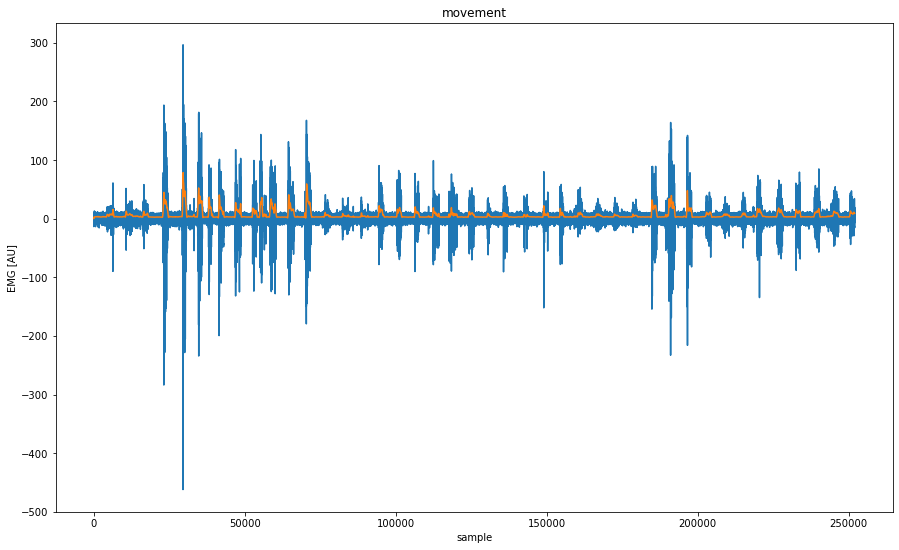

In [24]:
# plot one trial

low_cutoff = 5
start = 0
stop = -1
channel = 12

if not movement_session is None:
    plt.figure()
    hp = concat_movement_data[start:stop]
    lp = filter_emg(hp)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("movement")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


(767999, 64)
-0.9255616845188719 190.5918352017247
min channel:  26
0.00042121830864677546 190.5918352017247
(767999, 64)


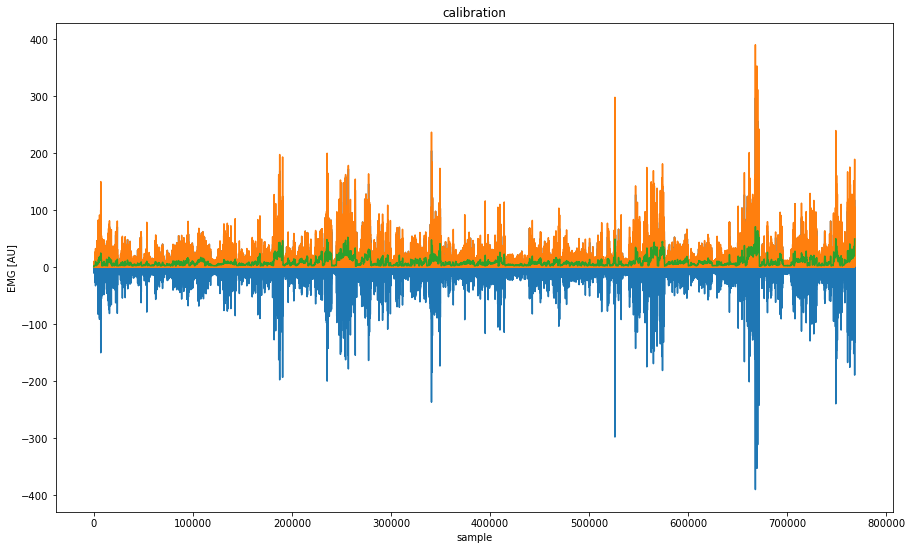

In [25]:

if not calibration_session is None:
    plt.figure()
    hp = concat_calibration_data[start:stop]
    r = analysis.rectify(hp)
    lp = filter_emg(hp)
    plt.plot(hp[:,15])
    plt.plot(r[:,15])
    plt.plot(lp[:,15])
    plt.title("calibration")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")


(93209, 64)


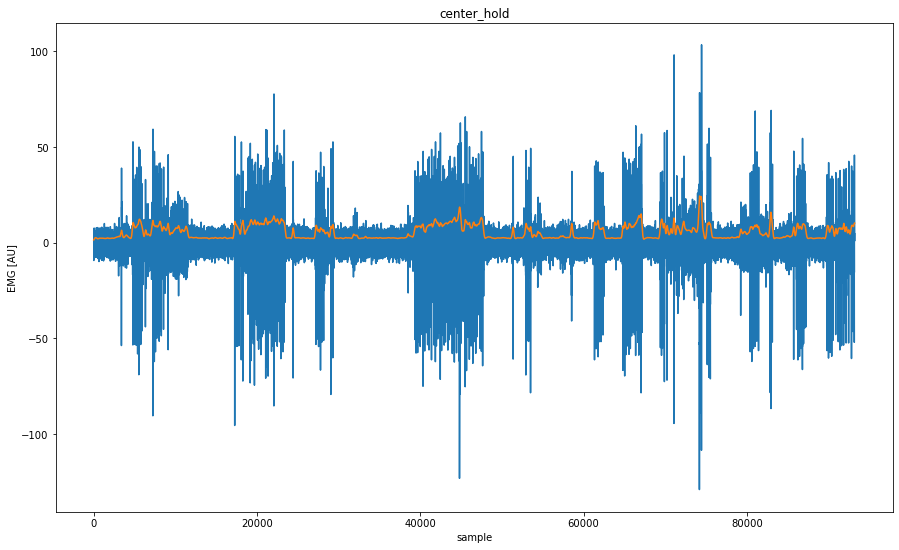

In [26]:
if not center_hold_session is None:
    plt.figure()
    hp = concat_center_hold_data[start:stop]
    lp = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(hp[:,channel])
    plt.plot(lp[:,channel])
    plt.title("center_hold")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

# inspect mean and var

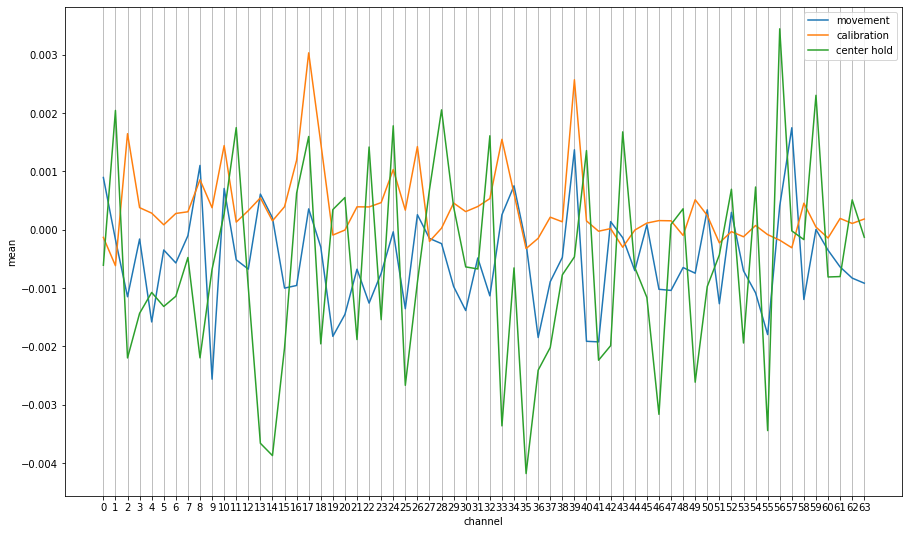

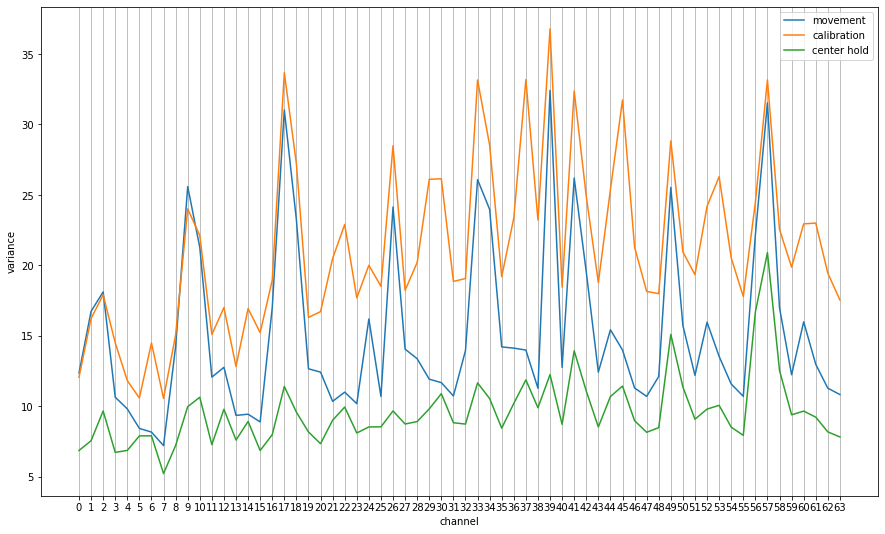

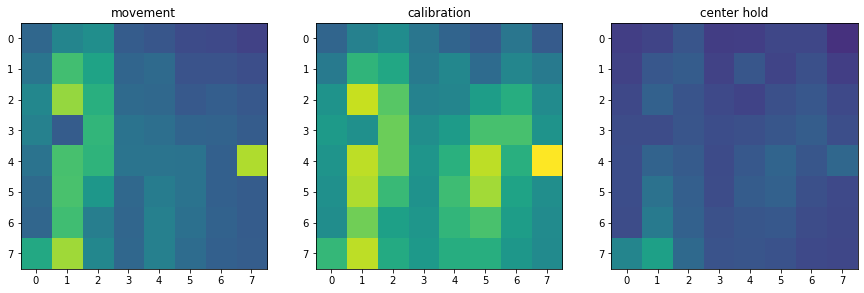

In [27]:
# mean
plt.figure()
if not movement_session is None:
    plt.plot(movement_means, label="movement")
if not calibration_session is None:
    plt.plot(calibration_means, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_means, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("mean")
plt.legend()

# variance
plt.figure()
if not movement_session is None:
    plt.plot(movement_vars, label="movement")
if not calibration_session is None:
    plt.plot(calibration_vars, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_vars, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("variance")
plt.legend()

maxes = []
if not movement_session is None:
    maxes.append(np.max(movement_vars))
if not calibration_session is None:
    maxes.append(np.max(calibration_vars))
if not center_hold_session is None:
    maxes.append(np.max(center_hold_vars))
maxmax = np.max(maxes)

fig, axes = plt.subplots(1,3)
if not movement_session is None:
    axes[0].imshow(movement_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[0].set_title("movement")
if not calibration_session is None:
    axes[1].imshow(calibration_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[1].set_title("calibration")
if not center_hold_session is None:
    axes[2].imshow(center_hold_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[2].set_title("center hold")

# compute and save variance scaling from calibration

In [28]:
v = np.diag(np.array(calibration_vars**-1, dtype=np.float32))
print(v)
print(v.shape)

# save decoder
subject_metadata_folder = utils.get_subject_folder(experiment="self_test", subject=subject)
assert subject_metadata_folder.exists()
utils.write_array_to_disk(a=v,path=subject_metadata_folder/"variance.bin")

[[0.0829341  0.         0.         ... 0.         0.         0.        ]
 [0.         0.06161543 0.         ... 0.         0.         0.        ]
 [0.         0.         0.05583241 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.04347661 0.         0.        ]
 [0.         0.         0.         ... 0.         0.05142961 0.        ]
 [0.         0.         0.         ... 0.         0.         0.05699414]]
(64, 64)


# compute offsets from movement

5
(18000, 64)
(18000, 64)
-0.13560725001127477 2.4121772252495988
min channel:  9
7.033406214323668e-05 2.4121772252495988
(18000, 64)


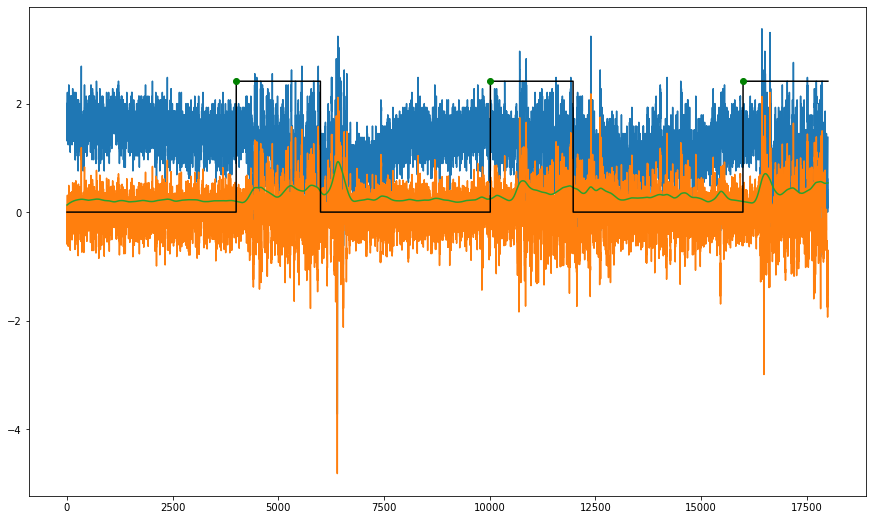

In [29]:
movements = list(md.keys())

channel = 3

signals = md[movements[0]]["emg"][:,:64]
print(high_cutoff)

std = standardize(signals,calibration_vars)
# print(std.shape)
hp = analysis.highpass(std,cutoff=high_cutoff)
# print(r.shape)
lp = filter_emg(hp)
# print(lp.shape)
cue = md[movements[0]]["cue"]
cue_on_indices = get_cue_on_indices(cue)

plt.figure()
plt.plot(std[:,channel])
plt.plot(hp[:,channel])
plt.plot(lp[:,channel])
plt.plot(cue*np.max(lp),"k")
plt.plot(cue_on_indices,np.max(lp)*np.ones(shape=(cue_on_indices.shape[0])),'go')

(63000, 64)
(63000, 64)
-0.03190195612151785 2.5341130636987867
min channel:  52
0.00040139748627223836 2.5341130636987867
(63000, 64)


Text(0.5, 1.0, 'quiescents')

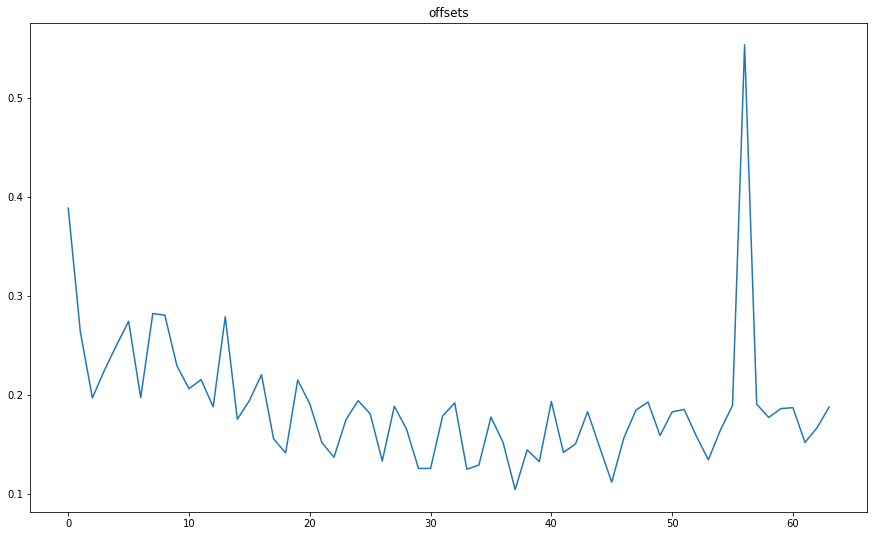

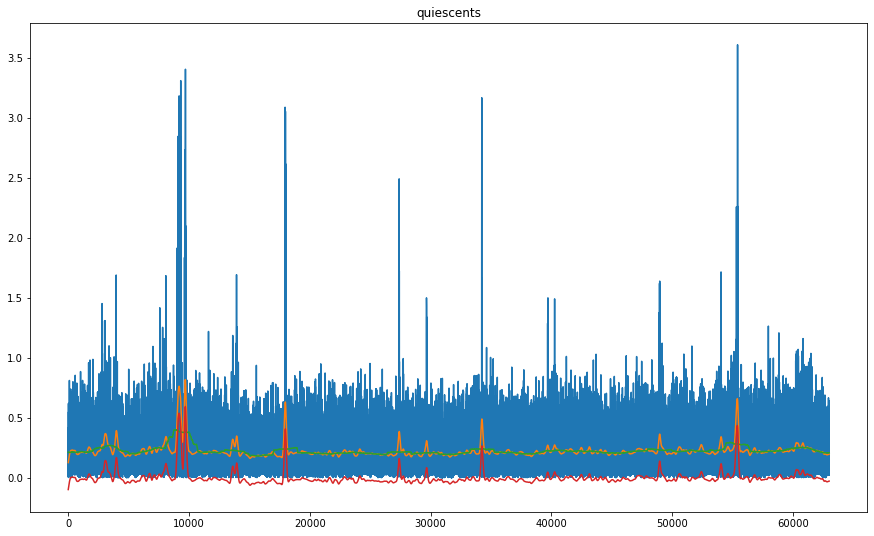

In [30]:
def extract_quiescent(md,samples_before_cue = 1500):
    quiescents = []
    movements = list(md.keys())
    for movement in movements:
        movement_emg = analysis.highpass(md[movement]["emg"],cutoff=3)[:,:64]
        cue = md[movement]["cue"]
        cue_on_indices = get_cue_on_indices(cue)
        # concat intra-movement signals before cues
        for idx in cue_on_indices:
            quiescents.append(movement_emg[idx-samples_before_cue:idx])

    return np.vstack(quiescents)

concat_quiescent_trials = extract_quiescent(md)

quiescent_window_length = 2000 # one second

standardized_concat_quiescent_trial = standardize(concat_quiescent_trials, calibration_vars)
r = analysis.rectify(standardized_concat_quiescent_trial)
lp = filter_emg(standardized_concat_quiescent_trial)
dc = analysis.moving_average(r,window_length=quiescent_window_length)

offsets = np.mean(lp,axis=0)

plt.figure()
plt.plot(offsets)
plt.title("offsets")

plt.figure()
plt.plot(r[:,channel])
plt.plot(lp[:,channel])
plt.plot(dc[:,channel])
plt.plot((lp-offsets)[:,channel])
plt.title("quiescents")


# standardize (variance), filter, shift (offset)

In [31]:
channel = 42

(768000, 64)
(768000, 64)
-0.03248383018053137 9.134211834234938
min channel:  26
2.0000078303493154e-05 9.134211834234938
(768000, 64)


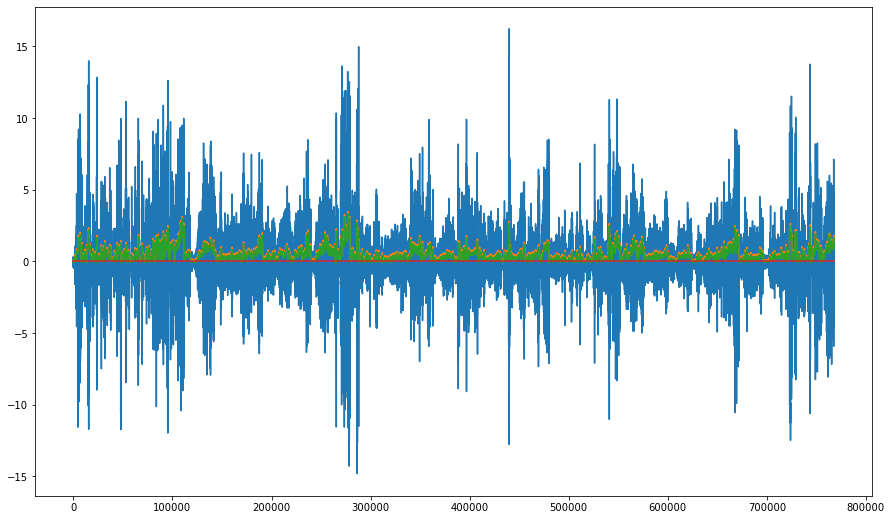

In [32]:
standardized_calibration_data = standardize(concat_calibration_data, calibration_vars)
filtered_calibration_data = filter_emg(standardized_calibration_data)
offset_calibration_data = np.subtract(filtered_calibration_data,offsets)
plt.plot(standardized_calibration_data[:,channel])
plt.plot(filtered_calibration_data[:,channel])
plt.plot(offset_calibration_data[:,channel])
plt.plot([0,filtered_calibration_data.shape[0]],[0,0])

(252000, 64)
(252000, 64)
-0.13560725001124044 7.612153382290279
min channel:  9
9.645500953620327e-06 7.612153382290279
(252000, 64)


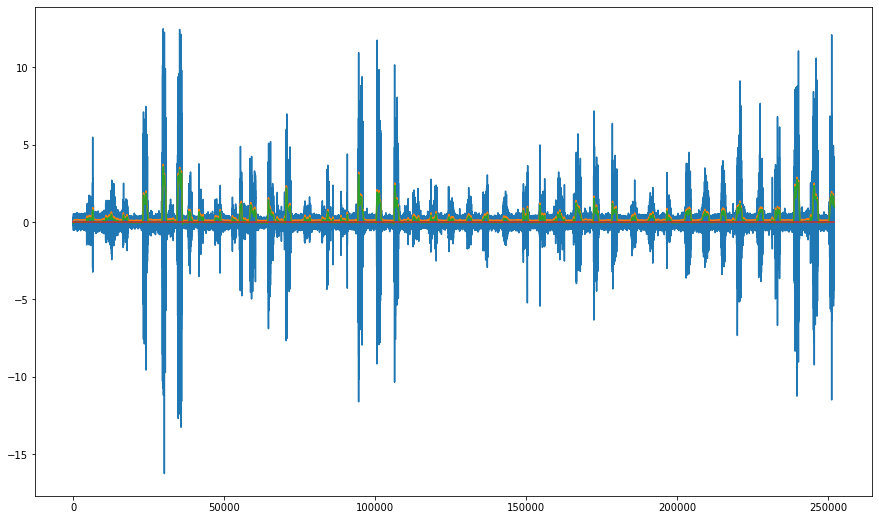

In [33]:
standardized_movement_data = standardize(concat_movement_data, calibration_vars)
filtered_movement_data = filter_emg(standardized_movement_data)
offset_movement_data = np.subtract(filtered_movement_data,offsets)
plt.plot(standardized_movement_data[:,channel])
plt.plot(filtered_movement_data[:,channel])
plt.plot(offset_movement_data[:,channel])
plt.plot([0,filtered_movement_data.shape[0]],[0,0])

# center hold

(104590, 64)
(104590, 64)
-0.056190071869743057 3.027142522738069
min channel:  47
2.1788716945335597e-05 3.027142522738069
(104590, 64)


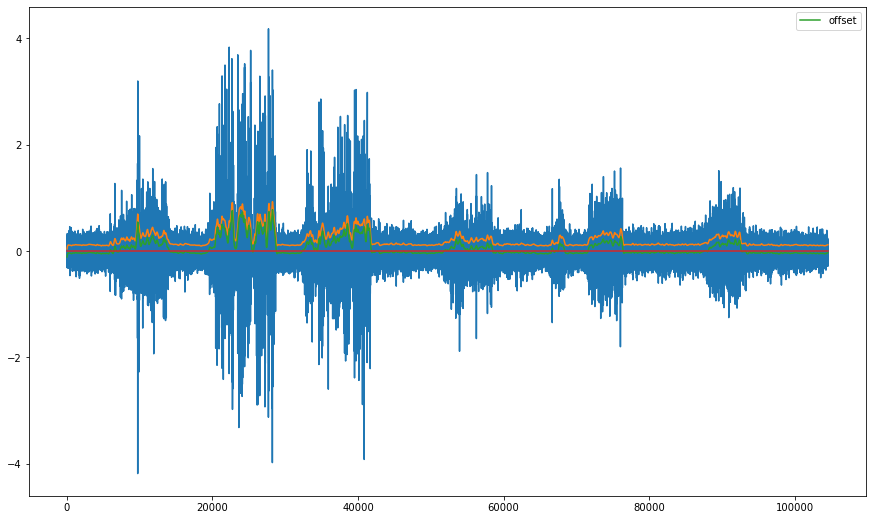

In [54]:
standardized_center_hold_data = standardize(concat_center_hold_data, calibration_vars)
filtered_center_hold_data = filter_emg(standardized_center_hold_data)
offset_center_hold_data = np.subtract(filtered_center_hold_data,offsets)
plt.plot(standardized_center_hold_data[:,channel])
plt.plot(filtered_center_hold_data[:,channel])
plt.plot(offset_center_hold_data[:,channel],label="offset")
plt.plot([0,filtered_center_hold_data.shape[0]],[0,0])
plt.legend()

# NMF

we L1-regularize the output (the projection of the data, W) to encourage the decoder to allow for single modes to be active at once

we can check this by looking at the correlation between the transformed data and seeking the least correlated projections

 W  x  H   =  X
Tx8 x 8x64 = Tx64
transformation x components = data

In [35]:
num_nmf_components = 8
nmf_model = NMF(n_components=num_nmf_components, max_iter=500, l1_ratio=0.9, regularization="transformation")
nmf_model.fit(filtered_calibration_data)
nmf_components = nmf_model.components_
factors = nmf_model.transform(filtered_calibration_data)
print("components: ", nmf_components.shape)
print("factors: ", factors.shape)

/Users/spencerw/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/spencerw/miniconda3/envs/motor/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


components:  (8, 64)
factors:  (768000, 8)


In [36]:
norms = np.linalg.norm(nmf_components,axis=1).reshape(num_nmf_components,1)
normalized_nmf_components = np.divide(nmf_components, norms)
print(normalized_nmf_components.shape)

factor_norms = np.linalg.norm(factors,axis=0)
normalized_factors = np.divide(factors,factor_norms)
print(normalized_factors.shape)

(8, 64)
(768000, 8)


0.35700877859389324 1.0000000000000442


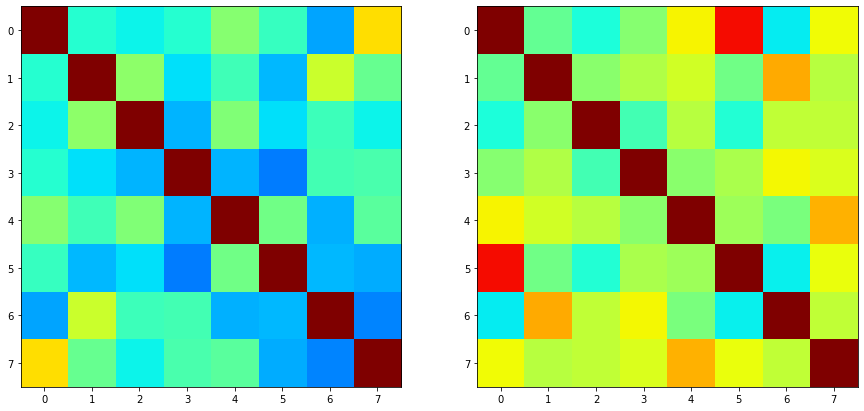

In [37]:
fig, axes = plt.subplots(1,2)

# mode covariance
axes[0].imshow(normalized_nmf_components@normalized_nmf_components.T,vmin=0,vmax=1,cmap="jet")

# factor covariance
c = normalized_factors.T@normalized_factors
print(c.min(),c.max())
axes[1].imshow(c,vmin=0,vmax=1,cmap="jet")

0.0 0.5740911861641543


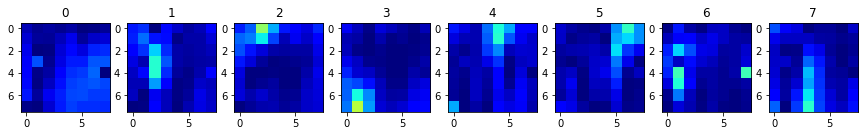

In [38]:
fig, axes = plt.subplots(1,num_nmf_components)
for i, (ax, c) in enumerate(zip(axes,normalized_nmf_components)):
    ax.imshow(c.reshape(8,8),vmin=0,vmax=1,cmap="jet")
    ax.set_title(i)
print(np.min(normalized_nmf_components),np.max(normalized_nmf_components))

In [39]:
component_idxs = [1,2,3,4]

# save decoder

In [40]:
# make decoder (right,left,down,up)
decoder = np.array(normalized_nmf_components[component_idxs],dtype=np.float32)
print(decoder.shape)

# convert to 2D (subtract up-down, left-right)
convert_to_2d = np.array([[1,-1,0,0],[0,0,-1,1]])
two_dim_decoder = np.dot(convert_to_2d, decoder)
print(two_dim_decoder.shape)

# save decoder
subject_metadata_folder = utils.get_subject_folder(experiment="self_test", subject=subject)
six_dim_decoder = np.array(np.vstack([np.zeros(shape=(4,64)), two_dim_decoder]),dtype=np.float32)
print(six_dim_decoder.shape)
print(six_dim_decoder.dtype)

utils.write_array_to_disk(six_dim_decoder, subject_metadata_folder/"decoder.bin")

(4, 64)
(2, 64)
(6, 64)
float32


# save model and components

In [95]:
subject_metadata = subject_metadata_folder/"metadata.json"

subject_metadata_dict = utils.get_subject_metadata("self_test",subject)
print(subject_metadata_dict)
subject_metadata_dict.update({"components":component_idxs})

with open(str(subject_metadata), mode="w") as fp:
    json.dump(subject_metadata_dict, fp)
    

with open(subject_metadata_folder/"nmf_model.pkl", 'wb') as fp:
    pickle.dump(nmf_model, fp)
    
with open(subject_metadata_folder/"nmf_model.pkl", 'rb') as fp:
    m = pickle.load(fp)
print(m.components_.shape)


{'components': [1, 2, 3, 4]}
(8, 64)


# load and test decoder

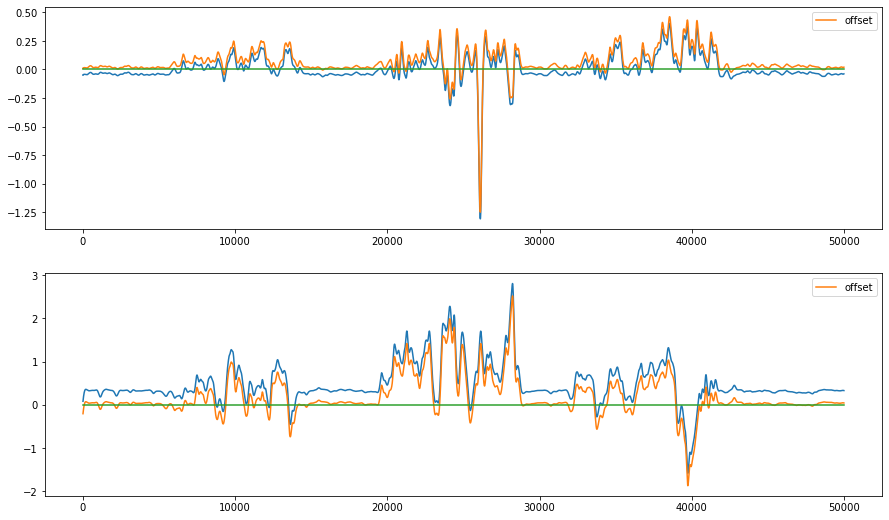

In [101]:
decoder = utils.load_array_from_disk(subject_metadata_folder/"decoder.bin").reshape(6,64)

# 2D preview
fig, axes = plt.subplots(2,1)
for ax, c in zip(axes,decoder[-2:]):
    baseline = np.dot(c,filtered_center_hold_data.T)
    ax.plot(baseline[:50000])
    baseline = np.dot(c,offset_center_hold_data.T)
    ax.plot(baseline[:50000],label="offset")
    ax.plot([0,50000],[0,0])
    ax.legend()

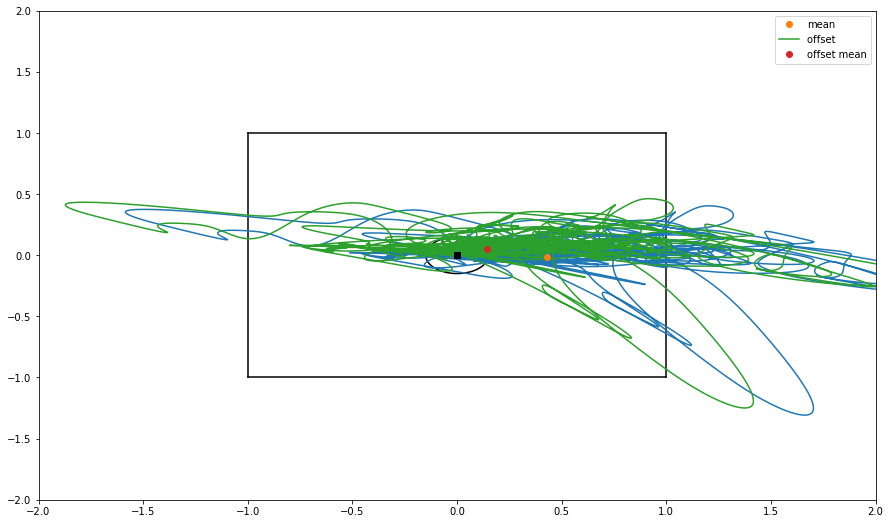

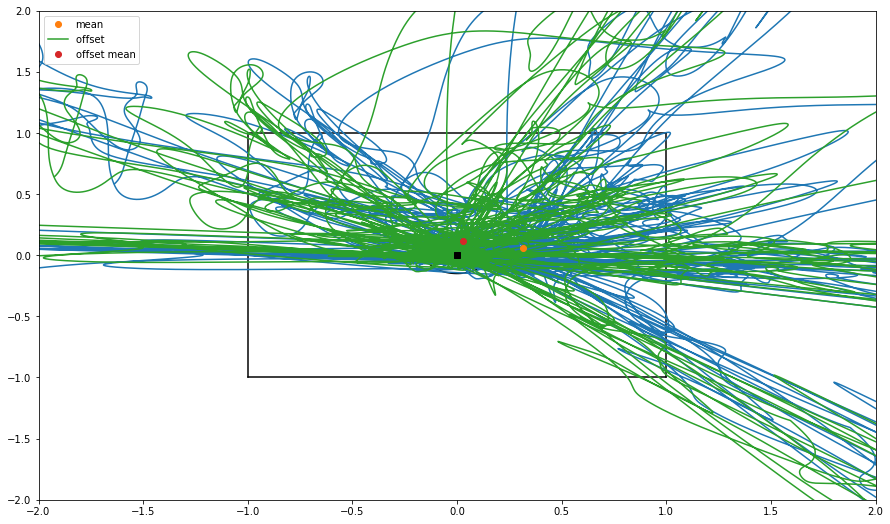

In [74]:
def plot_circle(x,y,r,ax,style="k"):
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(r*np.cos(theta)+x, r*np.sin(theta)+y,style)
    
def plot_box(ax):
    ax.plot(0,0,'ks',zorder=20)
    plot_circle(0,0,.15,ax)
    ax.plot([-1,1],[-1,-1],"k")
    ax.plot([-1,1],[1,1],"k")
    ax.plot([1,1],[-1,1],"k")
    ax.plot([-1,-1],[-1,1],"k")
    
def plot_control_preview(data, decoder, ax, label=""):
    ax.plot(np.dot(decoder[-1:],data.T)[0],np.dot(decoder[-2:-1],data.T)[0],label=label)
    ax.plot(np.dot(decoder[-1:],data.T)[0].mean(),np.dot(decoder[-2:-1],data.T)[0].mean(),"o",label=label+"mean",zorder=10)

fig, ax = plt.subplots(1,1)
ax.set_ylim([-2,2])
ax.set_xlim([-2,2])
plot_box(ax)
plot_control_preview(filtered_center_hold_data, decoder,ax)
plot_control_preview(offset_center_hold_data, decoder,ax,label="offset ")
ax.legend()

fig, ax = plt.subplots(1,1)
ax.set_ylim([-2,2])
ax.set_xlim([-2,2])
plot_box(ax)
plot_control_preview(filtered_movement_data, decoder,ax)
plot_control_preview(offset_movement_data, decoder,ax,label="offset ")
ax.legend()

In [104]:
# add the dynamics
experiment_metadata_dict = utils.get_experiment_metadata("self_test")
dynamics = generate_dynamics(decay=experiment_metadata_dict["decay"], tau=experiment_metadata_dict["tau"])
print(dynamics)
utils.write_array_to_disk(dynamics, subject_metadata_folder/"dynamics.bin")

[[0.4 0.  0.7 0.  0.  0. ]
 [0.  0.4 0.  0.7 0.  0. ]
 [0.  0.  0.4 0.  0.7 0. ]
 [0.  0.  0.  0.4 0.  0.7]
 [0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0. ]]


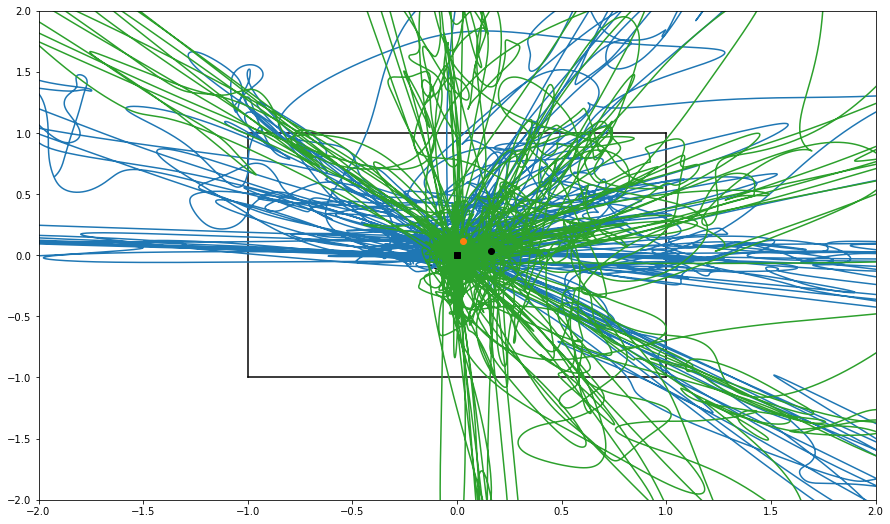

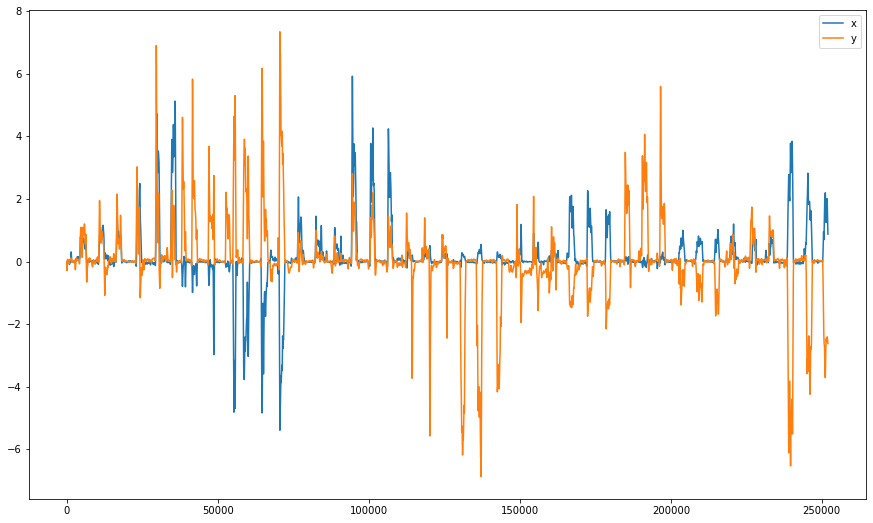

In [105]:
states = []
state = np.zeros(shape=(6,1))
for sample in offset_movement_data:
    state = utils.advance_dynamics(dynamics,state,decoder,sample.reshape(-1,1))
    states.append(state)
states = np.hstack(states)

fig, ax = plt.subplots(1,1)
ax.set_ylim([-2,2])
ax.set_xlim([-2,2])
plot_box(ax)
plot_control_preview(offset_movement_data, decoder, ax)
ax.plot(states[0],states[1])
plt.plot(states[0].mean(),states[1].mean(),"ko")

plt.figure()
plt.plot(states[0],label="x")
plt.plot(states[1],label="y")
plt.legend()

# PCA

In [ ]:
# get components -- channel-wise covariance
num_components = 3
pca_model = PCA(n_components=num_components)
pca_model.fit(filtered_calibration_data)
pca_components = pca_model.components_
print(pca_components.shape)

In [ ]:
# screeplots
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,num_components+1), pca_model.explained_variance_ratio_)
ax1.set_ylabel("explained_variance")
ax1.set_xlabel("component")

ax2.plot(range(1,num_components+1), pca_model.singular_values_)
ax2.set_ylabel("singular value")
ax2.set_xlabel("component")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(pca_components[i].reshape(8,8),vmin=np.min(pca_components),vmax=np.max(pca_components))
    ax.set_title(str(i))

plt.figure()
plt.plot(pca_components[0]*np.sqrt(pca_model.singular_values_[0]))
plt.plot(movement_vars)

In [ ]:
print(np.dot(components[0],components[1]))
print(np.dot(components[1],components[1]))
print(np.linalg.norm(components[0]))

# factor analysis

https://stackoverflow.com/questions/37221635/rotation-argument-for-scikit-learns-factor-analysis
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA
https://scikit-learn.org/stable/auto_examples/decomposition/plot_varimax_fa.html#sphx-glr-auto-examples-decomposition-plot-varimax-fa-py
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html
https://scikit-learn.org/stable/modules/decomposition.html#fa

In [ ]:
model = FactorAnalysis(n_components=num_components, random_state=0)
model.fit(standardized_data)
factors = model.components_
print(factors.shape)

In [ ]:
print(factors[0].shape)
print(np.dot(factors[0]/np.linalg.norm(factors[0]),
             factors[1]/np.linalg.norm(factors[1])))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,65), model.mean_)
ax1.set_ylabel("feature mean")
ax1.set_xlabel("feature")

ax2.plot(range(1,65), model.noise_variance_)
ax2.set_ylabel("feature noise variance")
ax2.set_xlabel("feature")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(factors[i].reshape(8,8))
    ax.set_title(str(i))